In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [418]:
data = pd.read_csv('insurance.csv')

In [419]:
sample_data = data.head()
with open("sample_data.tex", 'w') as f:
    f.write(sample_data.to_latex())

In [420]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [421]:
desc = data.describe(include = 'all')
with open("desc_data.tex", 'w') as f:
    f.write(desc.to_latex())

In [422]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

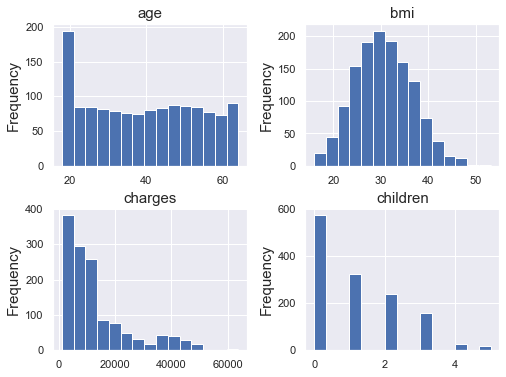

In [423]:
axs = numerical_data.hist(figsize=(8,6), bins=15)
for ax in axs.flatten():
    ax.set_ylabel('Frequency', fontsize=15)
    ax.set_title(ax.title.get_text(),fontdict = {'fontsize': 15})
plt.savefig('histograms.png')
plt.show()

In [424]:
obj_data = data.select_dtypes(include=['object'])
obj_data

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


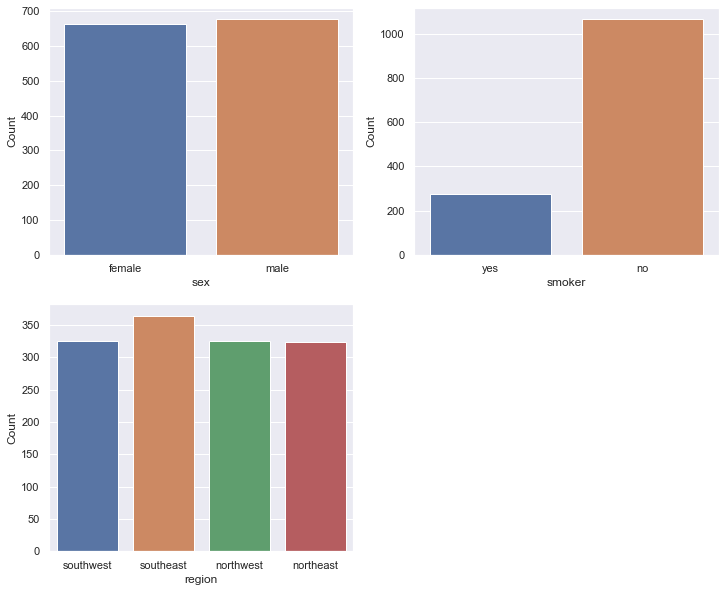

In [425]:
i=1
plt.figure(figsize=(12,10))
for col in obj_data.columns:
    plt.subplot(2,2,i)
    sb.countplot(obj_data[col])
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(col, fontsize=12)
    i=i+1
plt.savefig('barplots_cat.png')
plt.show()

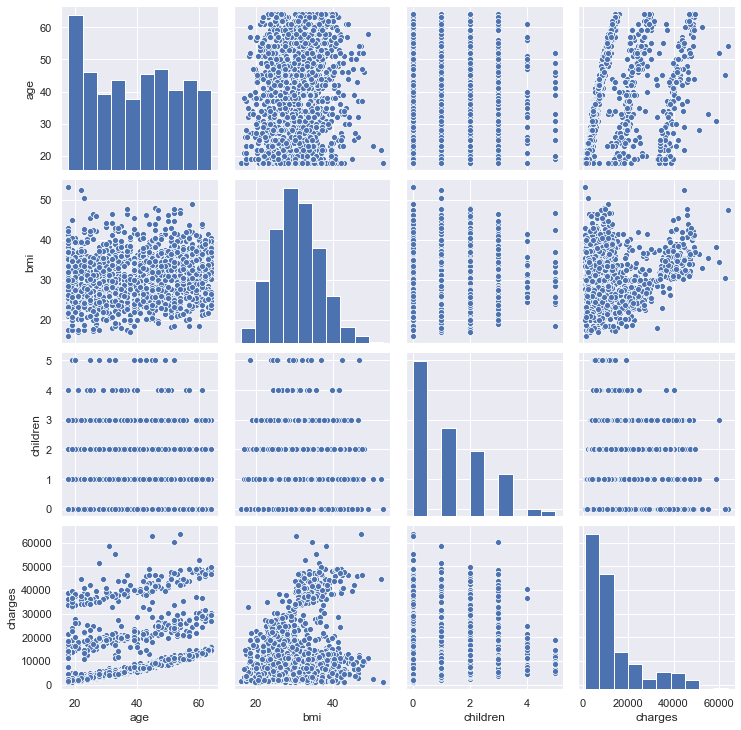

In [426]:
sb.set(font_scale=1)
sb.pairplot(data)
plt.savefig('pairplots.png')

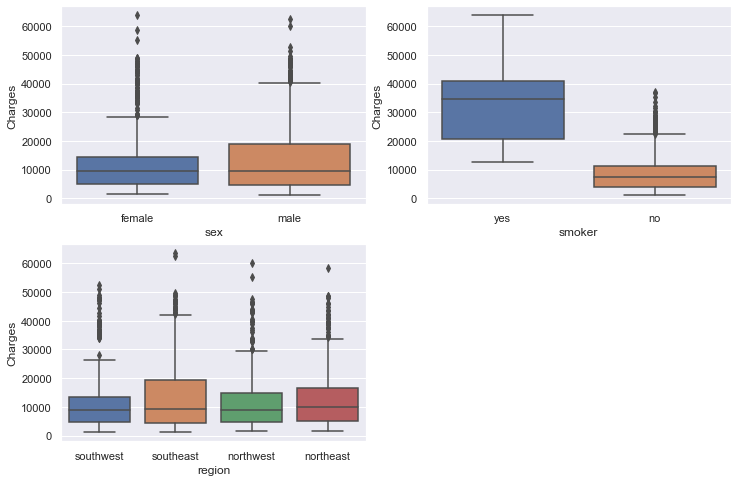

In [427]:
i=1
plt.figure(figsize=(12,8))
for col in obj_data.columns:
    plt.subplot(2,2,i)
    sb.boxplot(data=data, y = 'charges', x = col)
    plt.ylabel('Charges', fontsize=12)
    plt.xlabel(col, fontsize=12)
    i=i+1
plt.savefig('boxplots_cat.png')
plt.show()


In [428]:
from sklearn.preprocessing import OneHotEncoder

In [429]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['sex', 'smoker', 'region'], drop_first=True)
one_hot_encoded_data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [430]:
with open("sample_data_fe.tex", 'w') as f:
    f.write(one_hot_encoded_data.head().to_latex())

In [431]:
from scipy import stats
rvs1 = data[data['sex']=='male']['charges']
rvs2 = data[data['sex']=='female']['charges']
stats.ttest_ind(rvs1, rvs2, equal_var=True)

Ttest_indResult(statistic=2.097546590051688, pvalue=0.03613272100592976)

In [432]:
stats.ttest_ind(rvs1, rvs2, equal_var=False)

Ttest_indResult(statistic=2.1008878232359565, pvalue=0.035841014956016645)

In [433]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [434]:
#Train Test Split
y_col = 'charges'

feature_cols = [x for x in one_hot_encoded_data.columns if x != y_col]
X_data = one_hot_encoded_data[feature_cols]
y_data = one_hot_encoded_data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)

In [435]:
error_df = list()
score_df = list()

In [436]:
#Linear Regression
LR = LinearRegression(fit_intercept=False)
LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
error_df.append(pd.Series({'train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                           'test' : np.sqrt(mean_squared_error(y_test,  y_test_pred))},
                           name='LinearRegression'))
score_df.append(pd.Series({'train': np.sqrt(r2_score(y_train, y_train_pred)),
                           'test' : np.sqrt(r2_score(y_test,  y_test_pred))},
                           name='LinearRegression'))

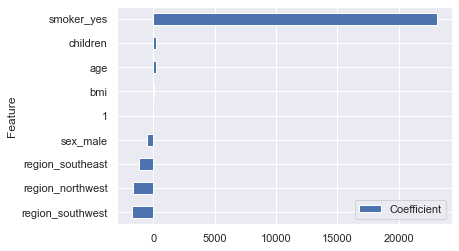

In [437]:
df_importances = pd.DataFrame(zip(num_cols+cat_cols+['1'],
                 np.concatenate((LR.coef_,np.array([LR.intercept_]))),
))

df_importances.sort_values(by=1)


df = df_importances.sort_values(by=1)
df = df.rename(columns={0:'Feature',1:'Coefficient'})
df.plot(kind='barh', x=0, y=1)
plt.savefig('LR_features.png',bbox_inches='tight')

In [438]:
#Add Polynomial Features
pf = PolynomialFeatures(degree=2)
cat_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
num_cols = ['age', 'bmi', 'children']
X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]
X_test_num = X_test[num_cols]
X_test_cat = X_test[cat_cols]
X_train_num_poly = pf.fit_transform(X_train_num)
X_train_poly = np.concatenate((X_train_num_poly, X_train_cat), axis=1) 
X_test_num_poly = pf.transform(X_test_num)
X_test_poly = np.concatenate((X_test_num_poly, X_test_cat), axis=1) 


In [439]:
X_test_poly.shape

(402, 15)

In [440]:
#Ploynomial Regression
LRP = LinearRegression()
LRP.fit(X_train_poly, y_train)
y_train_pred_poly = LRP.predict(X_train_poly)
y_test_pred_poly = LRP.predict(X_test_poly)
error_df.append(pd.Series({'train': np.sqrt(mean_squared_error(y_train, y_train_pred_poly)),
                           'test' : np.sqrt(mean_squared_error(y_test,  y_test_pred_poly))},
                           name='PolynmialLinearRegression'))
score_df.append(pd.Series({'train': np.sqrt(r2_score(y_train, y_train_pred_poly)),
                           'test' : np.sqrt(r2_score(y_test,  y_test_pred_poly))},
                           name='PolynomialLinearRegression'))

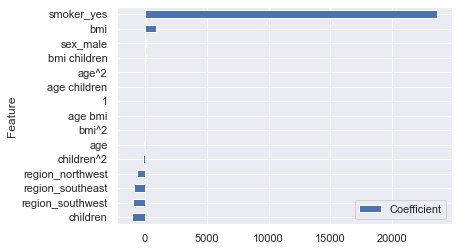

In [441]:

df_importances = pd.DataFrame(zip(pf.get_feature_names(num_cols)+cat_cols,
                 LRP.coef_,
))

df_importances.sort_values(by=1)


df = df_importances.sort_values(by=1)
df = df.rename(columns={0:'Feature',1:'Coefficient'})
df.plot(kind='barh', x=0, y=1)
plt.savefig('LRP_features.png', bbox_inches='tight')

In [442]:
#Lasso Regression without scaling


# Same estimator as before
estimator = Pipeline([("lasso_regression", Lasso(max_iter=10000))])

params = {
    'lasso_regression__alpha': np.geomspace(0.00001, 100, 1000)
}
kf = KFold(shuffle=True, random_state=72018, n_splits=5)
grid = GridSearchCV(estimator,params , cv=kf)

grid.fit(X_train_poly,y_train)

y_train_pred_lasso = grid.predict(X_train_poly)
y_test_pred_lasso = grid.predict(X_test_poly)

error_df.append(pd.Series({'train': np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)),
                           'test' : np.sqrt(mean_squared_error(y_test,  y_test_pred_lasso))},
                           name='LassoPolynmialLinearRegression'))
score_df.append(pd.Series({'train': np.sqrt(r2_score(y_train, y_train_pred_lasso)),
                           'test' : np.sqrt(r2_score(y_test,  y_test_pred_lasso))},
                           name='LassoPolynomialLinearRegression'))



In [443]:
grid.best_score_, grid.best_params_

(0.7388524588808211, {'lasso_regression__alpha': 93.7501501514529})

In [444]:
grid.best_estimator_.named_steps['lasso_regression'].coef_

array([ 0.00000000e+00, -5.39467148e+01,  7.47266711e+02, -0.00000000e+00,
        4.14618274e+00, -3.79457684e-01, -5.05985516e+00, -7.29484024e+00,
        4.34104696e+01, -1.48461977e+02,  0.00000000e+00,  2.30429327e+04,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [445]:
#Lasso Regression with scaling
LRL = Lasso()


# Same estimator as before
estimator_s = Pipeline([("scaler", StandardScaler()),
                      ("lasso_regression", Lasso(max_iter=10000))])

params = {
    'lasso_regression__alpha': np.geomspace(0.00001, 100, 1000)
}
kf = KFold(shuffle=True, random_state=72018, n_splits=5)
grid_s = GridSearchCV(estimator_s,params , cv=kf)

grid_s.fit(X_train_poly,y_train)

y_train_pred_lasso_s = grid_s.predict(X_train_poly)
y_test_pred_lasso_s = grid_s.predict(X_test_poly)

error_df.append(pd.Series({'train': np.sqrt(mean_squared_error(y_train, y_train_pred_lasso_s)),
                           'test' : np.sqrt(mean_squared_error(y_test,  y_test_pred_lasso_s))},
                           name='LassoScalePolynmialLinearRegression'))
score_df.append(pd.Series({'train': np.sqrt(r2_score(y_train, y_train_pred_lasso_s)),
                           'test' : np.sqrt(r2_score(y_test,  y_test_pred_lasso_s))},
                           name='LassoScalePolynomialLinearRegression'))

In [446]:
grid_s.best_score_, grid_s.best_params_

(0.7385029806883889, {'lasso_regression__alpha': 64.68607661546321})

In [447]:
grid_s.best_estimator_.named_steps['lasso_regression'].coef_

array([   0.        ,    0.        , 1811.37431042,   -0.        ,
       3683.63238153,    0.        ,    0.        ,    0.        ,
        802.62114824,  -95.58742031,    0.        , 9526.28933297,
        -28.4541266 , -198.34852904, -180.39816593])

In [448]:
rmse_df = pd.DataFrame(error_df)
rmse_tex = rmse_df.to_latex()
with open("rmse.tex", 'w') as f:
    f.write(rmse_tex)

In [449]:
score_df = pd.DataFrame(score_df)
score_tex = score_df.to_latex()
with open("score.tex", 'w') as f:
    f.write(score_tex)

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

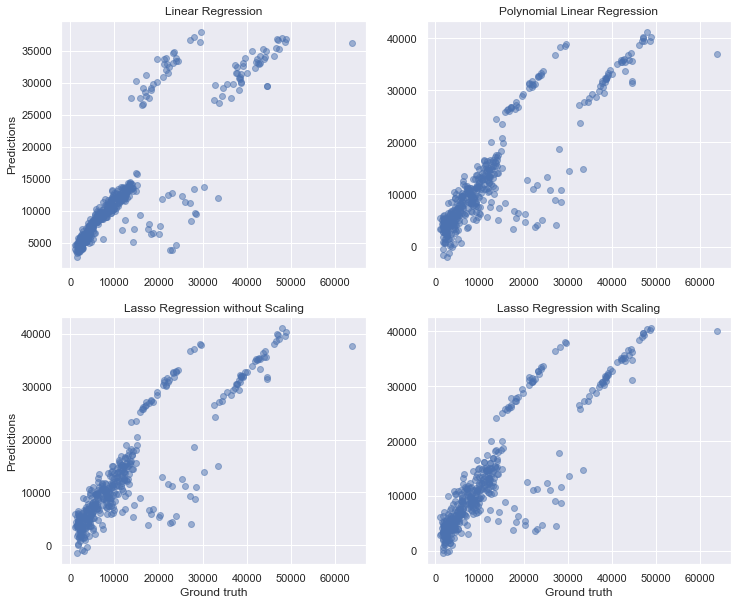

In [451]:


#sns.set_context('talk')
#sns.set_style('ticks')
#sns.set_palette('dark')
axs = plt.subplots(2,1, figsize=(12,10))
# we are going to use y_test, y_test_pred
ax = plt.subplot(2,2,1)
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(       ylabel='Predictions',
       title='Linear Regression');




# we are going to use y_test, y_test_pred
ax = plt.subplot(2,2,2)
ax.scatter(y_test, y_test_pred_poly, alpha=.5)

ax.set(
       title='Polynomial Linear Regression');



ax = plt.subplot(2,2,3)
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred_lasso, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Lasso Regression without Scaling');

ax = plt.subplot(2,2,4)
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred_lasso_s, alpha=.5)

ax.set(xlabel='Ground truth', 
       title='Lasso Regression with Scaling');
plt.savefig('predvstruth.png')
plt.show()

In [452]:
pf.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [453]:
pf.n_features_in_

3

In [454]:
pf.n_input_features_

3

In [455]:

pf.n_output_features_

10

In [456]:
n=3 
1+n+n+n*(n-1)/2

10.0

In [457]:
col_names_dict = dict(zip(list(range(len(X_train.columns.values))), X_train.columns.values))

In [458]:
col_names_dict

{0: 'age',
 1: 'bmi',
 2: 'children',
 3: 'sex_male',
 4: 'smoker_yes',
 5: 'region_northwest',
 6: 'region_southeast',
 7: 'region_southwest'}

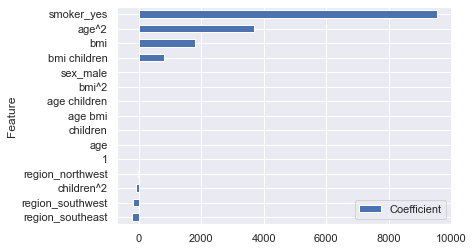

In [459]:
df_importances = pd.DataFrame(zip(pf.get_feature_names(num_cols)+cat_cols,
                 grid_s.best_estimator_.named_steps["lasso_regression"].coef_,
))

df_importances.sort_values(by=1)


df = df_importances.sort_values(by=1)
df = df.rename(columns={0:'Feature',1:'Coefficient'})
df.plot(kind='barh', x=0, y=1)
plt.savefig('Lasso_features.png',bbox_inches='tight')

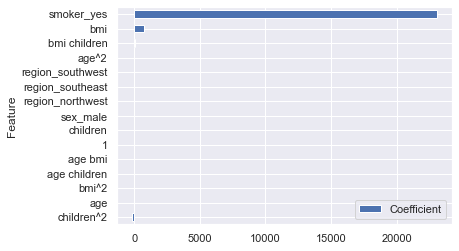

In [460]:
df_importances = pd.DataFrame(zip(pf.get_feature_names(num_cols)+cat_cols,
                 grid.best_estimator_.named_steps["lasso_regression"].coef_,
))

df_importances.sort_values(by=1)


df = df_importances.sort_values(by=1)
df = df.rename(columns={0:'Feature',1:'Coefficient'})
df.plot(kind='barh', x=0, y=1)
plt.savefig('LassoScale_features.png', bbox_inches='tight')